AttributeError: module 'matplotlib' has no attribute 'animation'

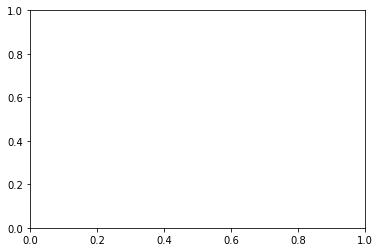

In [1]:
import numpy as np
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython


# TODO : generar en diferentes tiempos los carros

class Vehicle(ap.Agent):
    # TODO: corregir el metodo de movement para que el carro deje de moverse solamente cuando este adyacente al semaforo y este esté en rojo.
    # TODO: agregar que el carro se pare cuando tiene un carro en frente parado
    def setup(self):
        self.grid = self.model.grid
        self.pos = [0, 0]
        self.road = 2
        self.side = [1, 0]
        self.speed = 1
        self.crossed = False

    def direction(self):
        self.pos = self.grid.positions[self]
        if self.pos[1] == 0:
            self.side = [0, 1]

    def movement(self):
        self.direction()
        '''
        for stop in self.model.stop_sign:
            if stop.pos[0] - 1 == self.pos[0] or stop.pos[1] - 1 == self.pos[1]:
                if stop.status == 1:
                    self.grid.move_by(self, [self.speed * self.side[0], self.speed * self.side[1]])
                elif stop.status == 0:
                    self.grid.move_by(self, [self.speed * self.side[0], self.speed * self.side[1]])
        '''
        #self.grid.move_by(self, [self.speed * self.side[0], self.speed * self.side[1]])
        return (self.speed * self.side[0], self.speed * self.side[1])
    def route(self):
        self.pos = self.grid.positions[self]
        if self.pos[1] == 0:
            return 'HORIZONTAL'
        return 'VERTICAL'



class StopSign(ap.Agent):
     # TODO: Agregar metodo que calcule el cambio de estados del semaforo dependiendo de la cantidad de carros.
    def setup(self):
        self.status = 1
        self.road = 3
        self.grid = self.model.grid
        self.pos = [0, 0]

    def positions(self):
        self.pos = self.grid.positions[self]

    def change_state(self):
        self.status = 2
        if self.model.n_cars_1 > self.model.n_cars_2:
            if self.pos[0] == 5:
                self.status = 0
        elif self.model.n_cars_1 < self.model.n_cars_2:
            if self.pos[1] == 5:
                self.status = 0


class Roads(ap.Agent):
    def setup(self):
        self.road = 1
        self.condition = 1


class IntersectionModel(ap.Model):
    def setup(self):
        self.con=0
        # Define the grid. Hard coded 10x10
        tGrid = self.p['Grid']
        self.grid = ap.Grid(self, [tGrid] * 2, track_empty=True)

        self.n_cars_1 = 0
        self.n_cars_2 = 0

        # Define the agents
        n_vehicles = self.p['Vehicles']
        n_roads = tGrid*2

        # Define the agents representing the vehicles
        self.vehicles = ap.AgentList(self, n_vehicles, Vehicle)

        # Define the agents representing the road and the stop sign
        self.road = ap.AgentList(self, n_roads, Roads)
        self.stop_sign = ap.AgentList(self, 2, StopSign)

        # Creates the atribute grid in both agent vehicles in order to acces values like position
        self.vehicles.grid = self.grid

        # Location array, creates an array of tuples representing the location of the road tiles in the grid
        road_pos = []
        tGrid = self.p['Grid']
        for i in range(tGrid*2):
            if i <= tGrid-1:
                road_pos.append((i, int(tGrid/2)))
            else:
                road_pos.append((int(tGrid/2), i - tGrid))
            

        vehicles_positions=[]
        for i in range (1,n_vehicles+1):
            if i%2==0:
                vehicles_positions.append((int(tGrid/2), 0))
            else:
                vehicles_positions.append((0,int(tGrid/2)))

        # Add agents to the grid in their respective position
        self.grid.add_agents(self.road, road_pos)  # for loop adds road in order to do an intersection
        #for i in range(n_vehicles):
        #self.grid.add_agents(self.vehicles, positions=vehicles_positions)

        self.grid.add_agents(self.stop_sign, positions=[(int((tGrid/2)-1), int((tGrid/2)+1)), (int((tGrid/2)+1), int((tGrid/2)-1))])

    def step(self):
        # TODO: agregar logica para la interaccion entre el objeto semaforo y objeto vehiculo
        tGrid = self.p['Grid']
        n_vehicles = self.p['Vehicles']
        if self.con==0:
            vehicles_positions=[]
            positions=[(0, int(tGrid/2)), (int(tGrid/2), 0)]
            
            for i in range (n_vehicles):
                rand_pos = np.random.randint(0, 2)
                vehicles_positions.append(positions[rand_pos])
                if rand_pos == 1:
                    self.n_cars_1 += 1
                elif rand_pos == 0:
                    self.n_cars_2 += 1
                print(positions[rand_pos])
            
            new_car=ap.AgentList(self,1,Vehicle)
            self.grid.add_agents(self.vehicles,vehicles_positions)
            #print(vehicles_positions[rand_pos])
            self.con+=1

        print(self.n_cars_1)
        print(self.n_cars_2)
        
        n_movements=0
        move_cars=0
        movimiento=True
        moving_cars_1 = self.vehicles
        #moving_cars_1=moving_cars_1[2:]
        '''
        for car in moving_cars_1:
            coordinates_move=car.movement()
            self.grid.move_by(car,coordinates_move)
        '''
       
        for agent in self.grid.agents:
            agent_pos=self.grid.positions[agent]
            movimiento=True
            if agent.type == 'Vehicle':
                for neighbor in self.grid.neighbors(agent):
                    if agent.route() == 'HORIZONTAL':
                        if self.grid.positions[neighbor][1]==agent_pos[1]+1 and self.grid.positions[neighbor][0]==agent_pos[0]:
                            if neighbor.type=='Vehicle':
                                movimiento=False
                                break
                    elif agent.route() == 'VERTICAL':
                        if self.grid.positions[neighbor][0]==agent_pos[0]+1 and self.grid.positions[neighbor][1]==agent_pos[1]:
                            if neighbor.type=='Vehicle':
                                movimiento=False
                                break
                if movimiento:
                    coordinates_move=agent.movement()
                    self.grid.move_by(agent,coordinates_move)
                    
        
            #car.movement()
            #n_movements+=1
            #self.grid.add_agents(vehicles, positions=[(0, int((tGrid/2)+1)), (int((tGrid/2)+1), 0)])
        

        #self.new_car=hash(tuple(self.new_car))
        #coordinates_move=self.new_car[0].movement()
        #print(coordinates_move)
        #self.grid.move_by(self.new_car[0],coordinates_move)
        #if n_movements%10 == 0:
         #   for car2 in moving_cars_1[:2]:
          #      car2.movement()
                
        

    def end(self):
        pass


parameters = {
    'Vehicles': 10,
    'steps': 100,
    'Grid':25,
}


def animation_plot(model, ax):
    attr_grid = model.grid.attr_grid('road')
    color_dict = {0: '#d5e5d5', 1: '#e5e5e5', 2: '#d62c2c', 3: '#FFFF00', None: '#7FC97F'}  # '#d5e5d5' '#d62c2c'
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)


fig, ax = plt.subplots()
model = IntersectionModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=30))